# Quantum Chem. VQE-MUB Code, V2

Refactored to work with qiskit-nature 0.7.2 and qiskit 1.2.0.
Because everything else breaks all the way to hell.

Written by Ittay Alfassi, based on work from Dekel Meirom

### Required Versions:
- qiskit-nature==0.7.2  (via pip)
- pyscf==2.6.2          (via conda)
- matplotlib==3.9.2     (via conda)
- qiskit==1.2.0         (via pip, automatic when installing qiskit-nature)
- numpy==1.26.4         (built-in with conda)

### Required Infrastructure

- Linux or MacOS. **We highly recommend** to use the supplied dockerfile to set up a debian container.
- Miniconda3 (current version is conda 24.7.1)

## Imports

In [6]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit
import numpy as npwhich 
from numpy import sin,cos,pi,linspace,zeros
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector, SparsePauliOp
from qiskit.result import Counts, Result
from typing import Optional, List, Dict, Tuple, Union
from matplotlib import pyplot as plt
from itertools import product

### Quantum Chemistry Imports

In [7]:
from pyscf import scf
from pyscf import gto

In [8]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.drivers.electronic_structure_driver import MethodType

from qiskit_nature.second_q.problems.electronic_structure_problem import ElectronicStructureProblem
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

## Qubit operator generation functions

In [ ]:
from qiskit_nature.second_q.drivers import PySCFDriver, MethodType
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit.quantum_info import SparsePauliOp
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from typing import Optional

def get_method_type(method: str) -> MethodType:
    method = method.lower()
    return {
        "rhf": MethodType.RHF,
        "uhf": MethodType.UHF,
        "rohf": MethodType.ROHF,
        "rks": MethodType.RKS,
        "uks": MethodType.UKS
    }.get(method, MethodType.RHF)  # Default to RHF

def get_qubit_op( #This is the important function responsible for getting the hamiltonian to solve
    molecule_str: str,
    charge: int = 0,
    basis: str = "sto3g",
    mapping_name: str = "parity",
    transformer: Optional[ActiveSpaceTransformer] = None,
    method_type: str = "rhf",
    spin: int = 0
) -> tuple[ElectronicStructureProblem, SparsePauliOp]:
    driver = PySCFDriver(
        atom=molecule_str,
        unit=DistanceUnit.ANGSTROM,
        charge=charge,
        basis=basis,
        spin=spin,
        method=get_method_type(method_type),
    )
    problem = driver.run()
    
    if transformer:
        problem = transformer.transform(problem)
    
    second_q_op = problem.hamiltonian.second_q_op()

    mapper_classes = {
        "parity": ParityMapper,
        "jordan": JordanWignerMapper,
        "bravi": BravyiKitaevMapper,
    }
    
    mapper_class = mapper_classes.get(mapping_name)
    if mapper_class is None:
        print("Mapper should be one of 'parity', 'jordan', or 'bravi'.")
        return None
    
    mapper = mapper_class(num_particles=problem.num_particles)
    qubit_op = mapper.map(second_q_op)
    
    print("Number of particles:", problem.num_particles)
    print("Number of spatial orbitals:", problem.num_spatial_orbitals)
    print("Number of qubits:", qubit_op.num_qubits)
    print("Number of Paulis:", qubit_op.size)
    
    return qubit_op, problem


In [ ]:
def get_exact_energies(elec_struct_prob): #Works by a classical, naive eigensolver
    numpy_solver = NumPyMinimumEigensolver()
    mapper=ParityMapper()
    calc = GroundStateEigensolver(mapper, numpy_solver)
    temp_res = calc.solve(elec_struct_prob)
    return temp_res, temp_res.total_energies[0], temp_res.nuclear_repulsion_energy

#TODO: put here a quantum algorithm for solving the eigenvalues
def quantum_get_exact_energies(elec_struct_prob):
    pass

### Matrix Hamiltonians

In [11]:
def pauli_tensor_product(n, pauli_string):
    # Define Pauli matrices
    pauli_matrices = {
        'I': np.eye(2, dtype=complex),
        'X': np.array([[0, 1], [1, 0]], dtype=complex),
        'Y': np.array([[0, -1j], [1j, 0]], dtype=complex),
        'Z': np.array([[1, 0], [0, -1]], dtype=complex)
    }
    
    # Check if the input string length matches the number of qubits
    if len(pauli_string) != n:
        raise ValueError("Length of Pauli string must match the number of qubits (n).")
    
    # Start with the first matrix
    result = pauli_matrices[pauli_string[0]]
    
    # Perform the tensor product iteratively
    for char in pauli_string[1:]:
        result = np.kron(result, pauli_matrices[char])
    
    return result

def build_H_mat(H_op):
    n = len(H_op.paulis[0])
    num_strings = len(H_op.coeffs)
    H = np.zeros((2**n,2**n),dtype=np.complex128)
    for i in range(num_strings):
        coeff = H_op.coeffs[i]
        pauli = H_op.paulis[i]
        pauli_mat = pauli_tensor_product(n, pauli.to_label())
        H += coeff * pauli_mat 
    return H

def minimal_eigenvalue(matrix):
    # Compute eigenvalues using NumPy
    eigenvalues = np.linalg.eigvalsh(matrix)  # For Hermitian matrices (more efficient)
    return np.min(eigenvalues)

### Display Function for second-quanization Hamiltonian

## Several configutarions of LiH

The geometry, charge, set of basis elements, and mapping are the same. <br>
The active space transformers will differ. 

In [12]:
dist = "1.5"
atom_str = f"Li .0 .0 .0; H .0 .0 {dist}"
charge = 0
basis = 'sto3g'
mapping_name = "parity"

### (1) Default settings - 4 electrons and 6 spatial orbitals

In [13]:
transformer1 = None
LiH_qub_1, LiH_es_1 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer1)
# print('GS energy:',get_exact_energies(LiH_es_1)[1])
# print('GS energy:', minimal_eigenvalue(build_H_mat(LiH_qub_1)))
print(LiH_qub_1)
print(LiH_es_1.hamiltonian.second_q_op())
print('Energies:',get_exact_energies(LiH_es_1))

Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZX', 'IIIIIIIIIX', 'IIIIIIIZXX', 'IIIIIIIIYY', 'IIIIIXXXXX', 'IIIIIYXXXY', 'IIIIIIIIZZ', 'IIIIIIIZXZ', 'IIIIIIIIXI', 'IIIIIXXXXZ', 'IIIIIYXXYI', 'IIIIIIIZZI', 'IIIIIXXXZI', 'IIIIIYXYII', 'IIIIIIZZII', 'IIIIIZZIII', 'IIIIIZIIII', 'IIIIZIIIII', 'IIIZXIIIII', 'IIIIXIIIII', 'IIZXXIIIII', 'IIIYYIIIII', 'XXXXXIIIII', 'YXXXYIIIII', 'IIIZZIIIII', 'IIZXZIIIII', 'IIIXIIIIII', 'XXXXZIIIII', 'YXXYIIIIII', 'IIZZIIIIII', 'XXXZIIIIII', 'YXYIIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII', 'ZIIIIIIIII', 'IIIIIIIIZI', 'IIIIIIIZXI', 'IIIIIIIIXZ', 'IIIIIXXXXI', 'IIIIIYXXYZ', 'IIIIIIIZZZ', 'IIIIIXXXZZ', 'IIIIIYXYIZ', 'IIIIIIZZIZ', 'IIIIIZZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZXIIIIZ', 'IIIIXIIIIZ', 'IIZXXIIIIZ', 'IIIYYIIIIZ', 'XXXXXIIIIZ', 'YXXXYIIIIZ', 'IIIZZIIIIZ', 'IIZXZIIIIZ', 'IIIXIIIIIZ', 'XXXXZIIIIZ', 'YXXYIIIIIZ', 'IIZZIIIIIZ', 'XXXZIIIIIZ', 'YXYIIIIIIZ', 'I

### (2) Active space: 2 electrons, 2 spatial orbitals

In [14]:
transformer2 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
LiH_qub_2, LiH_es_2 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer2)
print('GS energy:', minimal_eigenvalue(build_H_mat(LiH_qub_2)))
# print('GS energy:',get_exact_energies(LiH_es_2)[1])
print(LiH_qub_2)
print(LiH_es_2.hamiltonian.second_q_op())
print('Energies:',get_exact_energies(LiH_es_2))

Number of particles: (1, 1)
Number of spatial orbitals: 2
Number of qubits: 2
Number of Paulis: 9
GS energy: -1.0816281947228503
SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XZ', 'ZX', 'XX'],
              coeffs=[-0.8283753 +0.j,  0.17399667+0.j,  0.02654859+0.j, -0.17399667+0.j,
  0.02654859+0.j, -0.09496265+0.j,  0.02654859+0.j, -0.02654859+0.j,
  0.01213863+0.j])
Fermionic Operator
number spin orbitals=4, number terms=72
  -0.787844741287685 * ( +_0 -_0 )
+ 0.0469345004088138 * ( +_0 -_1 )
+ 0.04693450040881391 * ( +_1 -_0 )
+ -0.3621174852767556 * ( +_1 -_1 )
+ -0.787844741287685 * ( +_2 -_2 )
+ 0.0469345004088138 * ( +_2 -_3 )
+ 0.04693450040881391 * ( +_3 -_2 )
+ -0.3621174852767556 * ( +_3 -_3 )
+ 0.24714174399725666 * ( +_0 +_0 -_0 -_0 )
+ -0.023467248713467732 * ( +_0 +_0 -_1 -_0 )
+ -0.023467248713467732 * ( +_0 +_1 -_0 -_0 )
+ 0.11331213551046078 * ( +_0 +_1 -_1 -_0 )
+ 0.24714174399725666 * ( +_0 +_2 -_2 -_0 )
+ -0.023467248713467732 * ( +_0 +_2 -_3 -_0 )
+ -0.02346

### (3) LiH with active orbitals 1,2 (out of 0,1,2,3)

In [15]:
transformer3 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2, active_orbitals=[1,2])
LiH_qub_3, LiH_es_3 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer3)
print('GS energy:',get_exact_energies(LiH_es_3)[1])
print(LiH_qub_3)
print(LiH_es_3.hamiltonian.second_q_op())

Number of particles: (1, 1)
Number of spatial orbitals: 2
Number of qubits: 2
Number of Paulis: 9
GS energy: -7.863579821677111
SparsePauliOp(['II', 'IZ', 'IX', 'ZI', 'XI', 'ZZ', 'XZ', 'ZX', 'XX'],
              coeffs=[-0.8283753 +0.j,  0.17399667+0.j,  0.02654859+0.j, -0.17399667+0.j,
  0.02654859+0.j, -0.09496265+0.j,  0.02654859+0.j, -0.02654859+0.j,
  0.01213863+0.j])
Fermionic Operator
number spin orbitals=4, number terms=72
  -0.7878447412876762 * ( +_0 -_0 )
+ 0.04693450040887377 * ( +_0 -_1 )
+ 0.04693450040887384 * ( +_1 -_0 )
+ -0.36211748527676996 * ( +_1 -_1 )
+ -0.7878447412876762 * ( +_2 -_2 )
+ 0.04693450040887377 * ( +_2 -_3 )
+ 0.04693450040887384 * ( +_3 -_2 )
+ -0.36211748527676996 * ( +_3 -_3 )
+ 0.2471417439972483 * ( +_0 +_0 -_0 -_0 )
+ -0.023467248713485968 * ( +_0 +_0 -_1 -_0 )
+ -0.023467248713485968 * ( +_0 +_1 -_0 -_0 )
+ 0.11331213551046847 * ( +_0 +_1 -_1 -_0 )
+ 0.2471417439972483 * ( +_0 +_2 -_2 -_0 )
+ -0.023467248713485968 * ( +_0 +_2 -_3 -_0 )
+ -0.02

### (4) Active space: 2 electrons, 2 spatial orbitals

In [16]:
transformer4 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=3)
LiH_qub_4, LiH_es_4 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer4)
print('GS energy:',get_exact_energies(LiH_es_4)[1])
print(LiH_qub_4)
print(LiH_es_4.hamiltonian.second_q_op())

Number of particles: (1, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 52
GS energy: -7.86440676493737
SparsePauliOp(['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIZZ', 'IIZI', 'IZII', 'ZXII', 'IXII', 'ZZII', 'ZIII', 'IZIZ', 'ZXIZ', 'IXIZ', 'ZZIZ', 'ZIIZ', 'IZZX', 'IZIX', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'ZZZX', 'ZZIX', 'ZIZX', 'ZIIX', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'IZZZ', 'ZXZZ', 'IXZZ', 'ZZZZ', 'ZIZZ', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'IZZI', 'ZXZI', 'IXZI', 'ZZZI', 'ZIZI'],
              coeffs=[-0.48073512+0.j, -0.03172577+0.j, -0.01445658+0.j,  0.01445658+0.j,
 -0.20749124+0.j,  0.21293828+0.j,  0.03172577+0.j,  0.01445658+0.j,
  0.01445658+0.j, -0.20749124+0.j, -0.21293828+0.j, -0.12357087+0.j,
  0.01173362+0.j,  0.01173362+0.j,  0.05665607+0.j,  0.06878552+0.j,
  0.01173362+0.j, -0.01173362+0.j, -0.00303466+0.j, -0.00303466+0.j,
  0.00303466+0.j,  0.00303466+0.j,  0.00154067+0.j, -0.00154067+0.j,
  0.0

### (5) LiH with active orbitals 1,2,5 (out of 0,1,2,3,4,5)

In [17]:
transformer5 = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=3, active_orbitals=[1,2,5])
LiH_qub_5, LiH_es_5 = get_qubit_op(atom_str, charge, basis, mapping_name, transformer5)
print('GS energy:',get_exact_energies(LiH_es_5)[1])
print(LiH_qub_5)
print(LiH_es_5.hamiltonian.second_q_op())

Number of particles: (1, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 100
GS energy: -7.881015715647108
SparsePauliOp(['IIII', 'IIIZ', 'IIZX', 'IIIX', 'IIXX', 'IIYY', 'IIZZ', 'IIXZ', 'IIXI', 'IIZI', 'IZII', 'ZXII', 'IXII', 'XXII', 'YYII', 'ZZII', 'XZII', 'XIII', 'ZIII', 'IZIZ', 'ZXIZ', 'IXIZ', 'XXIZ', 'YYIZ', 'ZZIZ', 'XZIZ', 'XIIZ', 'ZIIZ', 'IZZX', 'IZIX', 'ZXZX', 'IXZX', 'ZXIX', 'IXIX', 'XXZX', 'YYZX', 'XXIX', 'YYIX', 'ZZZX', 'ZZIX', 'XZZX', 'XIZX', 'XZIX', 'XIIX', 'ZIZX', 'ZIIX', 'IZXX', 'IZYY', 'ZXXX', 'IXXX', 'ZXYY', 'IXYY', 'XXXX', 'YYXX', 'XXYY', 'YYYY', 'ZZXX', 'ZZYY', 'XZXX', 'XIXX', 'XZYY', 'XIYY', 'ZIXX', 'ZIYY', 'IZZZ', 'ZXZZ', 'IXZZ', 'XXZZ', 'YYZZ', 'ZZZZ', 'XZZZ', 'XIZZ', 'ZIZZ', 'IZXZ', 'IZXI', 'ZXXZ', 'IXXZ', 'ZXXI', 'IXXI', 'XXXZ', 'YYXZ', 'XXXI', 'YYXI', 'ZZXZ', 'ZZXI', 'XZXZ', 'XIXZ', 'XZXI', 'XIXI', 'ZIXZ', 'ZIXI', 'IZZI', 'ZXZI', 'IXZI', 'XXZI', 'YYZI', 'ZZZI', 'XZZI', 'XIZI', 'ZIZI'],
              coeffs=[-1.99754128e-01+0.j, -9.17966070

## LiH GS energy as function of distance

Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Pa

NameError: name 'x_min' is not defined

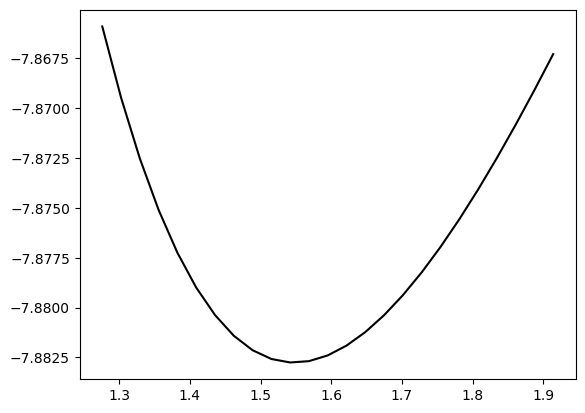

In [18]:

# Constants
known_dist = 1.595
N = 25
Rs = np.linspace(0.8 * known_dist, 1.2 * known_dist, N)
energies = np.zeros(len(Rs))

# Energy calculation
for i, R in enumerate(Rs):
    atom_str = f"Li .0 .0 .0; H .0 .0 {R}"
    qubit_op, es = get_qubit_op(atom_str, charge, basis, mapping_name)
    energies[i] = get_exact_energies(es)[1]


# Find real minimum and simulated middle point
min_index = np.argmin(energies)  # Index of minimum energy
mid_index = N // 2  # Middle index of Rs

margine_const = 0.05
plt.axis([min(Rs) - margine_const * (max(Rs) - min(Rs)), 
          max(Rs) + margine_const * (max(Rs) - min(Rs)), 
          min(energies) - margine_const * (max(energies) - min(energies)), 
          max(energies) + margine_const * (max(energies) - min(energies))])

# Get updated limits
x_L, x_R, y_L, y_R = plt.axis()

# Plot energy curve
plt.plot(Rs, energies, label="Energy Curve", color="black")

# Add scatter points
plt.scatter(x_min, y_min, color="red", label=f"Real Min: Distance={x_min:.3f}, E={y_min:.3f}")
plt.scatter(x_mid, y_mid, color="blue", label=f"Simulated: Distance={x_mid:.3f}, E={y_mid:.3f}")

# Add dashed lines
# simulation min
plt.axhline(y_min, 0, (x_min-x_L)/(x_R-x_L), linestyle=":", color="red")
plt.axvline(x_min, 0, (y_min-y_L)/(y_R-y_L), linestyle=":", color="red")

# known min
plt.axhline(y_mid, 0, (x_mid-x_L)/(x_R-x_L), linestyle=":", color="blue")
plt.axvline(x_mid, 0, (y_mid-y_L)/(y_R-y_L), linestyle=":", color="blue")

# Labels and title
plt.xlabel("d [Angstrom]")
plt.ylabel("GS energy [Hartree]")
plt.title("LiH Energy vs Distance")
plt.legend()
plt.show()


## H2O GS energy at known molecule geometry

In [19]:
known_R = 0.9584
known_theta = 104.5 * pi / 180  # Convert to radians

atom_str = (
    f"O .0 .0 .0; "
    f"H {known_R * sin(known_theta / 2):.3f} {known_R * cos(known_theta / 2):.3f} .0; "
    f"H {-known_R * sin(known_theta / 2):.3f} {known_R * cos(known_theta / 2):.3f} .0"
)

charge = 0
basis = 'sto6g'
mapping_name = "parity"

# transformer_H2O = ActiveSpaceTransformer(num_electrons=4, num_spatial_orbitals=4)
transformer_H2O = None

H2O_qub, H2O_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer_H2O)
# print('GS energy:',get_exact_energies(H2O_es)[1])
# print('GS energy:', minimal_eigenvalue(build_H_mat(H2O_qub)))
print(H2O_qub)
print(H2O_es.hamiltonian.second_q_op())
print('Energies:',get_exact_energies(H2O_es))

Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
SparsePauliOp(['IIIIIIIIIIII', 'IIIIIIIIIIIZ', 'IIIIIIIIIIZX', 'IIIIIIIIIIIX', 'IIIIIIIIZXXX', 'IIIIIIIIIYXY', 'IIIIIIZXXXXX', 'IIIIIIIYXXXY', 'IIIIIIIIIIZZ', 'IIIIIIIIZXXZ', 'IIIIIIIIIYYI', 'IIIIIIZXXXXZ', 'IIIIIIIYXXYI', 'IIIIIIIIIZZI', 'IIIIIIXXXXZI', 'IIIIIIYXXYII', 'IIIIIIIIZZII', 'IIIIIIZXXZII', 'IIIIIIIYYIII', 'IIIIIIIZZIII', 'IIIIIIZZIIII', 'IIIIIIZIIIII', 'IIIIIZIIIIII', 'IIIIZXIIIIII', 'IIIIIXIIIIII', 'IIZXXXIIIIII', 'IIIYXYIIIIII', 'ZXXXXXIIIIII', 'IYXXXYIIIIII', 'IIIIZZIIIIII', 'IIZXXZIIIIII', 'IIIYYIIIIIII', 'ZXXXXZIIIIII', 'IYXXYIIIIIII', 'IIIZZIIIIIII', 'XXXXZIIIIIII', 'YXXYIIIIIIII', 'IIZZIIIIIIII', 'ZXXZIIIIIIII', 'IYYIIIIIIIII', 'IZZIIIIIIIII', 'ZZIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIIIIZI', 'IIIIIIIIZXXI', 'IIIIIIIIIYYZ', 'IIIIIIZXXXXI', 'IIIIIIIYXXYZ', 'IIIIIIIIIZZZ', 'IIIIIIXXXXZZ', 'IIIIIIYXXYIZ', 'IIIIIIIIZZIZ', 'IIIIIIZXXZIZ', 'IIIIIIIYYIIZ', 'IIIIIIIZZIIZ', 'II

## H2O GS energy as function of distance and angle

In [20]:
# Constants and initialization
known_R = 0.9584
known_theta = 104.5 * pi / 180  # Convert to radians
N = 11 # choose an odd number so that the known minimum is included in linspace
Rs = linspace(0.6, 1.4, N) * known_R  # Generate scaled bond lengths
thetas = linspace(0.6, 1.4, N) * known_theta  # Generate scaled bond angles
energies = np.zeros((len(Rs), len(thetas)))  # Initialize energy grid

transformer_H2O = ActiveSpaceTransformer(num_electrons=4, num_spatial_orbitals=4)
# transformer_H2O = None

# Calculate energies
for i, R in enumerate(Rs):
    for j, theta in enumerate(thetas):
        atom_str = (
            f"O .0 .0 .0; "
            f"H {R * sin(theta / 2):.3f} {R * cos(theta / 2):.3f} .0; "
            f"H {-R * sin(theta / 2):.3f} {R * cos(theta / 2):.3f} .0"
        )
        H2O_qub, H2O_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer_H2O)
        energies[i, j] = get_exact_energies(H2O_es)[1]
        print('GS energy=',energies[i, j],'R=',R,'theta=',theta)

# Create meshgrid and contour plot
X, Y = np.meshgrid(Rs, thetas * (180/pi))  # Create 2D grid for Rs and thetas
plt.figure(figsize=(len(Rs), len(thetas)))
contour = plt.contourf(X, Y, energies.T, levels=50, cmap='viridis')  # Transpose energies for correct orientation
plt.colorbar(contour, label='Energy [Hartree]')
plt.xlabel('R [Angstrom]')
plt.ylabel('Theta [degrees]')

# Add a point of known vals (should be middle vals in linspace)
plt.scatter(known_R, known_theta * (180/pi), color='red', marker='o')
plt.text(known_R - 0.1, known_theta * (180/pi) -3, f"Known min at (R,Theta)=(0.9584,104.5). E={energies[N//2][N//2]:.4f}", color='red', fontsize=10)

# Add a point of simulation min vals
min_index = np.unravel_index(np.argmin(energies, axis=None), energies.shape)
x_min, y_min, z_min = Rs[min_index[0]], thetas[min_index[1]], energies[min_index]
plt.scatter(x_min, y_min * (180/pi), color='cyan', marker='o')
plt.text(x_min - 0.1, y_min * (180/pi) -3, f"Simulation min E={z_min:.4f}", color='cyan', fontsize=10)


plt.title('Contour Plot of H2O Energy')
plt.show()

Number of particles: (2, 2)
Number of spatial orbitals: 4
Number of qubits: 6
Number of Paulis: 95
GS energy= -74.44887119067009 R= 0.57504 theta= 1.0943214410004445
Number of particles: (2, 2)
Number of spatial orbitals: 4
Number of qubits: 6
Number of Paulis: 95
GS energy= -74.53075124951235 R= 0.57504 theta= 1.2402309664671705
Number of particles: (2, 2)
Number of spatial orbitals: 4
Number of qubits: 6
Number of Paulis: 95
GS energy= -74.5843747226522 R= 0.57504 theta= 1.3861404919338964
Number of particles: (2, 2)
Number of spatial orbitals: 4
Number of qubits: 6
Number of Paulis: 95
GS energy= -74.62804141011523 R= 0.57504 theta= 1.5320500174006224
Number of particles: (2, 2)
Number of spatial orbitals: 4
Number of qubits: 6
Number of Paulis: 95
GS energy= -74.65373347747226 R= 0.57504 theta= 1.6779595428673484
Number of particles: (2, 2)
Number of spatial orbitals: 4
Number of qubits: 6
Number of Paulis: 95
GS energy= -74.67145533066237 R= 0.57504 theta= 1.8238690683340741
Numbe

KeyboardInterrupt: 

In [ ]:
# Constants and initialization
known_R = 0.9584
known_theta = 104.5 * pi / 180  # Convert to radians
N = 11 # choose an odd number so that the known minimum is included in linspace
Rs = linspace(0.6, 1.4, N) * known_R  # Generate scaled bond lengths
thetas = linspace(0.6, 1.4, N) * known_theta  # Generate scaled bond angles
energies = np.zeros((len(Rs), len(thetas)))  # Initialize energy grid

# transformer_H2O = ActiveSpaceTransformer(num_electrons=4, num_spatial_orbitals=4)
transformer_H2O = None

# Calculate energies
for i, R in enumerate(Rs):
    for j, theta in enumerate(thetas):
        atom_str = (
            f"O .0 .0 .0; "
            f"H {R * sin(theta / 2):.3f} {R * cos(theta / 2):.3f} .0; "
            f"H {-R * sin(theta / 2):.3f} {R * cos(theta / 2):.3f} .0"
        )
        H2O_qub, H2O_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer_H2O)
        energies[i, j] = get_exact_energies(H2O_es)[1]
        print('GS energy=',energies[i, j],'R=',R,'theta=',theta)

# Create meshgrid and contour plot
X, Y = np.meshgrid(Rs, thetas * (180/pi))  # Create 2D grid for Rs and thetas
plt.figure(figsize=(len(Rs), len(thetas)))
contour = plt.contourf(X, Y, energies.T, levels=50, cmap='viridis')  # Transpose energies for correct orientation
plt.colorbar(contour, label='Energy [Hartree]')
plt.xlabel('R [Angstrom]')
plt.ylabel('Theta [degrees]')


# Add a point of known vals (should be middle vals in linspace)
plt.scatter(known_R, known_theta * (180/pi), color='red', marker='o')
plt.text(known_R - 0.1, known_theta * (180/pi) -3, f"Known min at (R,Theta)=(0.9584,104.5). E={energies[N//2][N//2]:.4f}", color='red', fontsize=10)

# Add a point of simulation min vals
min_index = np.unravel_index(np.argmin(energies, axis=None), energies.shape)
x_min, y_min, z_min = Rs[min_index[0]], thetas[min_index[1]], energies[min_index]
plt.scatter(x_min, y_min * (180/pi), color='cyan', marker='o')
plt.text(x_min - 0.1, y_min * (180/pi) -3, f"Simulation min E={z_min:.4f}", color='cyan', fontsize=10)


plt.title('Contour Plot of H2O Energy')
plt.show()

Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
GS energy= -74.46672770427554 R= 0.57504 theta= 1.0943214410004445
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
GS energy= -74.54785380003445 R= 0.57504 theta= 1.2402309664671705
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
GS energy= -74.60069033555858 R= 0.57504 theta= 1.3861404919338964
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
GS energy= -74.64372048012467 R= 0.57504 theta= 1.5320500174006224
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
GS energy= -74.6689135177205 R= 0.57504 theta= 1.6779595428673484
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
GS energy= -74.68629924912085 R= 0.57504 theta= 1.8238

KeyboardInterrupt: 

: 

: 

: 

: 

: 

: 

: 

: 

## RHF VS UHF

In [23]:
### Molecule geometries

# H2
atom_str_H2 = f"H .0 .0 .0; H .0 .0 0.74"

# HeH+
atom_str_HeH = f"He .0 .0 .0; H .0 .0 0.77"

# LiH
atom_str_LiH = f"Li .0 .0 .0; H .0 .0 1.6"

# Water
R=0.9584
theta=104.5 * pi / 180
atom_str_H2O = (
            f"O .0 .0 .0; "
            f"H {R * sin(theta / 2):.3f} {R * cos(theta / 2):.3f} .0; "
            f"H {-R * sin(theta / 2):.3f} {R * cos(theta / 2):.3f} .0"
        )
def get_fermionic_Ham(atom_str, charge, basis, mapping_name, transformer=None, method_type="rhf", spin=0):
    H2_qub, H2_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer, method_type, spin)
    return H2_es.hamiltonian.second_q_op()

def get_GS_energy(atom_str, charge, basis, mapping_name, transformer=None, method_type="rhf", spin=0):
    H2_qub, H2_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer, method_type, spin)
    GS_energy = get_exact_energies(H2_es)[1]
    return GS_energy

### They are similar (defulat settings, no need for active space)
Fermioni_Ham_H2_RHF = get_fermionic_Ham(atom_str=atom_str_H2, charge=0, basis='sto3g', mapping_name='parity', method_type='rhf')
Fermion_Ham_H2_UHF = get_fermionic_Ham(atom_str=atom_str_H2, charge=0, basis='sto3g', mapping_name='parity', method_type='uhf')
Fermion_Ham_HeH_RHF = get_fermionic_Ham(atom_str=atom_str_HeH, charge=1, basis='sto3g', mapping_name='parity', method_type='rhf')
Fermion_Ham_HeH_UHF = get_fermionic_Ham(atom_str=atom_str_HeH, charge=1, basis='sto3g', mapping_name='parity', method_type='uhf')

### Vary the active space. 
Fermion_Ham_LiH_RHF = get_fermionic_Ham(atom_str=atom_str_LiH, charge=0, basis='sto3g', mapping_name='parity', transformer=transformer4, method_type='rhf')
Fermion_Ham_LiH_UHF = get_fermionic_Ham(atom_str=atom_str_LiH, charge=0, basis='sto3g', mapping_name='parity', transformer=transformer4, method_type='uhf')

print('GS enrgies by method RHF,UHF,ROHF. With sto3g and sto6g basis sets')
### GS energy for LiH - to compare with the FCI energy
GS_energy_LiH_RHF3 = get_GS_energy(atom_str=atom_str_LiH, charge=0, basis='sto3g', mapping_name='parity', transformer=None, method_type='rhf')
GS_energy_LiH_UHF3 = get_GS_energy(atom_str=atom_str_LiH, charge=0, basis='sto3g', mapping_name='parity', transformer=None, method_type='uhf')
GS_energyLiH_ROHF3 = get_GS_energy(atom_str=atom_str_LiH, charge=0, basis='sto3g', mapping_name='parity', transformer=None, method_type='rohf')
GS_energy_LiH_RHF6 = get_GS_energy(atom_str=atom_str_LiH, charge=0, basis='sto6g', mapping_name='parity', transformer=None, method_type='rhf')
GS_energy_LiH_UHF6 = get_GS_energy(atom_str=atom_str_LiH, charge=0, basis='sto6g', mapping_name='parity', transformer=None, method_type='uhf')
GS_energyLiH_ROHF6 = get_GS_energy(atom_str=atom_str_LiH, charge=0, basis='sto6g', mapping_name='parity', transformer=None, method_type='rohf')
print('LiH:')
print('sto3g:')
print('RHF:',GS_energy_LiH_RHF3,'UHF:',GS_energy_LiH_UHF3,'RHOF:', GS_energyLiH_ROHF3)
print('sto6g:')
print('RHF:',GS_energy_LiH_RHF6,'UHF:',GS_energy_LiH_UHF6,'RHOF:', GS_energyLiH_ROHF6)
print('\n')

### GS energy for H2O - to compare with the FCI energy
GS_energy_H2O_RHF3 = get_GS_energy(atom_str=atom_str_H2O, charge=0, basis='sto3g', mapping_name='parity', transformer=None, method_type='rhf')
GS_energy_H2O_UHF3 = get_GS_energy(atom_str=atom_str_H2O, charge=0, basis='sto3g', mapping_name='parity', transformer=None, method_type='uhf')
GS_energy_H2O_ROHF3 = get_GS_energy(atom_str=atom_str_H2O, charge=0, basis='sto6g', mapping_name='parity', transformer=None, method_type='rohf')
GS_energy_H2O_RHF6 = get_GS_energy(atom_str=atom_str_H2O, charge=0, basis='sto6g', mapping_name='parity', transformer=None, method_type='rhf')
GS_energy_H2O_UHF6 = get_GS_energy(atom_str=atom_str_H2O, charge=0, basis='sto6g', mapping_name='parity', transformer=None, method_type='uhf')
GS_energy_H2O_ROHF6 = get_GS_energy(atom_str=atom_str_H2O, charge=0, basis='sto6g', mapping_name='parity', transformer=None, method_type='rohf')
print('\n')

print('H2O:')
print('sto3g:')
print('RHF:',GS_energy_H2O_RHF3,'UHF:',GS_energy_H2O_UHF3,'RHOF:', GS_energy_H2O_ROHF3)
print('sto6g:')
print('RHF:',GS_energy_H2O_RHF6,'UHF:',GS_energy_H2O_UHF6,'RHOF:', GS_energy_H2O_ROHF6)


Number of particles: (1, 1)
Number of spatial orbitals: 2
Number of qubits: 2
Number of Paulis: 5
Number of particles: (1, 1)
Number of spatial orbitals: 2
Number of qubits: 2
Number of Paulis: 5
Number of particles: (1, 1)
Number of spatial orbitals: 2
Number of qubits: 2
Number of Paulis: 9
Number of particles: (1, 1)
Number of spatial orbitals: 2
Number of qubits: 2
Number of Paulis: 9
Number of particles: (1, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 52


The following error was encountered during the attempted conversion of the 4-fold to 8-fold symmetric integrals: Expected a symmetric tensor.
The provided alpha-beta overlap matrix is NOT unitary! This can happen when the alpha- and beta-spin orbitals do not span the same space. To provide an example of what this means, consider an active space chosen from unrestricted-spin orbitals. Computing <S^2> within this active space may not result in the same <S^2> value as obtained on the single-reference starting point. More importantly, this implies that the inactive subspace will account for the difference between these two <S^2> values, possibly resulting in significant spin contamination in both subspaces. You should verify whether this is intentional/acceptable or whether your choice of active space can be improved. As a reference, here is the summed-absolute deviation of `S^T @ S` from the identity: 1.102868178602737


Number of particles: (1, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 52
GS enrgies by method RHF,UHF,ROHF. With sto3g and sto6g basis sets
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631


The following error was encountered during the attempted conversion of the 4-fold to 8-fold symmetric integrals: Expected a symmetric tensor.


Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 767
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631


The following error was encountered during the attempted conversion of the 4-fold to 8-fold symmetric integrals: Expected a symmetric tensor.


Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 767
Number of particles: (2, 2)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 631
LiH:
sto3g:
RHF: -7.88232437888353 UHF: -7.882324378883504 RHOF: -7.882324378883541
sto6g:
RHF: -7.972249851370504 UHF: -7.972249851370489 RHOF: -7.97224985137055


Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086


The following error was encountered during the attempted conversion of the 4-fold to 8-fold symmetric integrals: Expected a symmetric tensor.


Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086


The following error was encountered during the attempted conversion of the 4-fold to 8-fold symmetric integrals: Expected a symmetric tensor.


Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086
Number of particles: (5, 5)
Number of spatial orbitals: 7
Number of qubits: 12
Number of Paulis: 1086


H2O:
sto3g:
RHF: -75.01282317655584 UHF: -75.01282317655543 RHOF: -75.72907801309373
sto6g:
RHF: -75.7290780130936 UHF: -75.72907801309375 RHOF: -75.72907801309371


In [24]:
##### RHF H2 Fermionic Hamiltonian #####
print('RHF H2 Fermionic Hamiltonian:')
print(Fermion_Ham_H2_RHF_mat)

RHF H2 Fermionic Hamiltonian:


NameError: name 'Fermion_Ham_H2_RHF_mat' is not defined

In [ ]:
##### UHF H2 Fermionic Hamiltonian #####
print('UHF H2 Fermionic Hamiltonian:')
print(Fermion_Ham_H2_UHF_mat)

In [ ]:
##### RHF HeH Fermionic Hamiltonian #####
print('RHF HeH Fermionic Hamiltonian')
print(Fermion_Ham_HeH_RHF_mat)

In [ ]:
##### UHF HeH Fermionic Hamiltonian #####
print('UHF HeH Fermionic Hamiltonian')
print(Fermion_Ham_HeH_UHF_mat)

In [ ]:
##### RHF LiH Fermionic Hamiltonian #####
print('RHF LiH Fermionic Hamiltonian')
print(Fermion_Ham_LiH_RHF_mat)

In [ ]:
##### UHF LiH Fermionic Hamiltonian with Active Space#####
print('UHF LiH Fermionic Hamiltonian')
print(Fermion_Ham_LiH_UHF_mat)

# Reactions
### H2 + H -> H3

Number of particles: (2, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 52
R1=0.50, R2=0.50 → Energy = -1.170532 Ha
Number of particles: (2, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 100
R1=0.50, R2=0.58 → Energy = -1.266439 Ha
Number of particles: (2, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 100
R1=0.50, R2=0.66 → Energy = -1.331566 Ha
Number of particles: (2, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 100
R1=0.50, R2=0.74 → Energy = -1.377406 Ha
Number of particles: (2, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 100
R1=0.50, R2=0.82 → Energy = -1.410688 Ha
Number of particles: (2, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 100
R1=0.50, R2=0.89 → Energy = -1.435482 Ha
Number of particles: (2, 1)
Number of spatial orbitals: 3
Number of qubits: 4
Number of Paulis: 100
R1=0.50, R2=0.97 → Energy = -1.454330 Ha
Number of part

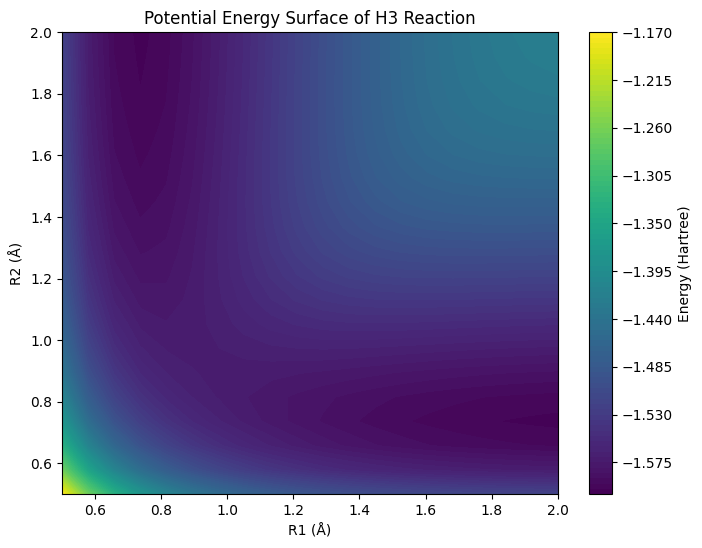

In [25]:
# Should I add this? gpt says so.
#spin=1  # Doublet state (since neutral H3 has an unpaired electron)


# Define grid
L=20
R1_values = np.linspace(0.5, 2.0,L)  # Range of R1 in Å
R2_values = np.linspace(0.5, 2.0,L)  # Range of R2 in Å

pes_data = []

for R1 in R1_values:
    for R2 in R2_values:

        # Define atom string
        atom_string_H3 = f"H .0 .0 .0; H {R1:.3f} .0 .0; H {(R1+R2):.3f} .0 .0"
        # Create molecule
        GS_energy = get_GS_energy(atom_str=atom_string_H3, charge=0, basis='sto3g', mapping_name='parity', transformer=None, method_type="rhf", spin=1)
        pes_data.append((R1, R2, GS_energy))

        
        print(f"R1={R1:.2f}, R2={R2:.2f} → Energy = {GS_energy:.6f} Ha")

# Convert data to arrays
R1_list, R2_list, E_list = zip(*pes_data)
R1_grid = np.reshape(R1_list, (L,L))
R2_grid = np.reshape(R2_list, (L,L))
E_grid = np.reshape(E_list, (L,L))

plt.figure(figsize=(8, 6))
plt.contourf(R1_grid, R2_grid, E_grid, levels=100, cmap="viridis")
plt.colorbar(label="Energy (Hartree)")
plt.xlabel("R1 (Å)")
plt.ylabel("R2 (Å)")
plt.title("Potential Energy Surface of H3 Reaction")
plt.show()


### H2 + CO2 -> HCOOH

In [26]:


    
# Should I add this? gpt says so.
#spin=1  # Doublet state (since neutral H3 has an unpaired electron)


# fixed parameters
r1 = 1
r2 = 2

# Define grid
L=1
R_values = np.linspace(0.5, 2.0,L)  # Range of R in Å
theta_values = np.linspace(0.1,pi,L) # Range of Theta in radians (0 to pi radians, 
                                    ### is this a good choice?!?!) ### !!! ###

pes_data = []

for R in R_values:
    for theta in theta_values:

        # Define atom string
        atom_string_H3 = f'''H {-R:.3f} {0.5*r1:.3f} .0; 
                             H {-R:.3f} {-0.5*r2:.3f} .0; 
                             C .0 .0 .0
                             O {r2*cos(theta/2):.3f} {r2*sin(theta/2):.3f} .0
                             O {r2*cos(theta/2):.3f} {-r2*sin(theta/2):.3f} .0'''
        # Create molecule

        # Possible active space transformers:
        transformer1 = ActiveSpaceTransformer(num_electrons=6,num_spatial_orbitals=6)
        GS_energy = get_GS_energy(atom_str=atom_string_H3, charge=0, basis='sto3g', mapping_name='parity', transformer=transformer1, method_type="rhf", spin=0)
        # pes_data.append((R1, R2, GS_energy))

        
        # print(f"R1={R1:.2f}, R2={R2:.2f} → Energy = {GS_energy:.6f} Ha")

# Convert data to arrays
# R1_list, R2_list, E_list = zip(*pes_data)
# R1_grid = np.reshape(R1_list, (L,L))
# R2_grid = np.reshape(R2_list, (L,L))
# E_grid = np.reshape(E_list, (L,L))

# plt.figure(figsize=(8, 6))
# plt.contourf(R1_grid, R2_grid, E_grid, levels=100, cmap="viridis")
# plt.colorbar(label="Energy (Hartree)")
# plt.xlabel("R1 (Å)")
# plt.ylabel("R2 (Å)")
# plt.title("Potential Energy Surface of H3 Reaction")
# plt.show()


Number of particles: (3, 3)
Number of spatial orbitals: 6
Number of qubits: 10
Number of Paulis: 1079


## CO2 molecule

In [27]:
known_R = 1.16

atom_str = (
    f"C .0 .0 .0; "
    f"O  .0 .0 {-known_R}; "
    f"O .0 .0 {known_R}"
)

charge = 0
basis = 'sto3g'
mapping_name = "parity"

transformer_CO2 = ActiveSpaceTransformer(num_electrons=2,num_spatial_orbitals=2)

H2O_qub, H2O_es = get_qubit_op(atom_str, charge, basis, mapping_name, transformer_CO2)
# print('GS energy:',get_exact_energies(H2O_es)[1]) 
# print('GS energy:', minimal_eigenvalue(build_H_mat(H2O_qub)))
print(H2O_qub)
print(H2O_es.hamiltonian.second_q_op())
print('Energies:',get_exact_energies(H2O_es))

Number of particles: (1, 1)
Number of spatial orbitals: 2
Number of qubits: 2
Number of Paulis: 5
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[-0.90877658+0.j,  0.23321314+0.j, -0.23321314+0.j, -0.03488221+0.j,
  0.14813493+0.j])
Fermionic Operator
number spin orbitals=4, number terms=36
  -0.9463417080956507 * ( +_0 -_0 )
+ -0.472546834573325 * ( +_1 -_1 )
+ -0.9463417080956507 * ( +_2 -_2 )
+ -0.472546834573325 * ( +_3 -_3 )
+ 0.27618138191744307 * ( +_0 +_0 -_0 -_0 )
+ 0.2376148781500337 * ( +_0 +_1 -_1 -_0 )
+ 0.27618138191744307 * ( +_0 +_2 -_2 -_0 )
+ 0.2376148781500337 * ( +_0 +_3 -_3 -_0 )
+ 0.07406746434748514 * ( +_0 +_0 -_1 -_1 )
+ 0.07406746434748514 * ( +_0 +_1 -_0 -_1 )
+ 0.07406746434748514 * ( +_0 +_2 -_3 -_1 )
+ 0.07406746434748514 * ( +_0 +_3 -_2 -_1 )
+ 0.07406746434748514 * ( +_1 +_0 -_1 -_0 )
+ 0.07406746434748514 * ( +_1 +_1 -_0 -_0 )
+ 0.07406746434748514 * ( +_1 +_2 -_3 -_0 )
+ 0.07406746434748514 * ( +_1 +_3 -_2 -_0 )
+ 0.2376148781500337

In [28]:


# Define molecules and their spin multiplicity
molecules = {
    "H2": ("H 0 0 0; H 0 0 0.74", 0),  # spin = 0 for closed-shell molecules
    "LiH": ("Li 0 0 0; H 0 0 1.6", 0),
    "H2O": ("O 0 0 0; H 0 0.76 0.58; H 0 -0.76 0.58", 0),
}

# Basis sets
basis_sets = ["sto-3g", "sto-6g"]

# HF methods
hf_methods = {
    "RHF": scf.RHF,  # Generic HF (let PySCF decide the type)
    "UHF": scf.UHF,  # Restricted HF
    "ROHF": scf.ROHF,  # Restricted Open-Shell HF
}

# Store results
results = []

# Iterate over (molecule, basis)
for (mol_name, (atom_str, spin)), basis in product(molecules.items(), basis_sets):
    # Define molecule in PySCF
    mol = gto.M(atom=atom_str, basis=basis, spin=spin, charge=0)

    # Compute FCI energy only once per molecule
    driver = PySCFDriver(atom=atom_str, basis=basis, spin=spin)
    problem = driver.run()
    qubit_mapper = JordanWignerMapper()
    hamiltonian = qubit_mapper.map(problem.hamiltonian.second_q_op())

    solver = NumPyMinimumEigensolver()
    fci_energy = solver.compute_minimum_eigenvalue(hamiltonian).eigenvalue.real

    # Store FCI energy
    results.append((mol_name, basis, "FCI", fci_energy))

    # Compute HF, RHF, and ROHF
    for hf_name, hf_class in hf_methods.items():
        mf = hf_class(mol)
        hf_energy = mf.kernel()
        results.append((mol_name, basis, hf_name, hf_energy))

# Pretty print results
print("\nComparison of HF, RHF, ROHF, and FCI Energies:\n")
print(f"{'Molecule':<10} {'Basis':<7} {'Method':<6} {'Energy':>12}")
print("=" * 40)
for mol, basis, method, energy in results:
    print(f"{mol:<10} {basis:<7} {method:<6} {energy:12.8f}")


converged SCF energy = -1.11675930739643
converged SCF energy = -1.11675930739643  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.11675930739643
converged SCF energy = -1.12537219464375
converged SCF energy = -1.12537219464375  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.12537219464375
converged SCF energy = -7.86186476980865
converged SCF energy = -7.86186476978944  <S^2> = 3.7932857e-10  2S+1 = 1
converged SCF energy = -7.86186476980865
converged SCF energy = -7.95180496344701
converged SCF energy = -7.9518049634282  <S^2> = 3.5752334e-10  2S+1 = 1
converged SCF energy = -7.951804963447
converged SCF energy = -74.9624891153372
converged SCF energy = -74.9624891153381  <S^2> = 1.5196733e-12  2S+1 = 1
converged SCF energy = -74.9624891153372
converged SCF energy = -75.6782528024108
converged SCF energy = -75.6782528024112  <S^2> = 1.9557689e-12  2S+1 = 1
converged SCF energy = -75.6782528024108

Comparison of HF, RHF, ROHF, and FCI Energies:

Molecule   Basis   Method       Energy
H2 